# 불균형데이터의 예측 성능

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

# START GUIDE 101
## How to deal with an imbalanced dataset
https://medium.com/analytics-vidhya/how-to-deal-with-an-imbalanced-dataset-47c8ce98c459

# 허위양성 파라독스

### 불균형 데이터가 인지적 오류를 줄 수 있는 경우를 살펴보자. 
- 전체 인구가 1,000명인 도시에 수도물 알러지가 있는 사람을 1%이고
- 알러지 진단 테스트는 99% 정확하다고 가정한다.

In [3]:
cross = np.array([[9801, 99], [0, 100]])
data = pd.DataFrame(cross, index=['정상인', '비정상인'], 
                    columns=['(정상판정)Test negative', '(알러지판정)Test positive'])
data['Total']= data.sum(axis=1)
data.loc['Total'] = data.sum()
data

,(정상판정)Test negative,(알러지판정)Test positive,Total
정상인,9801,99,9900
비정상인,0,100,100
Total,9801,199,10000


### 알러지가 없는데 있다고 진단할 확률은 1%, 알러지가 있다면 항상 100% 알러지 진단을 한다
### 허위양성율과 참양성율이 각각 1%와 100%라는 의미이다.

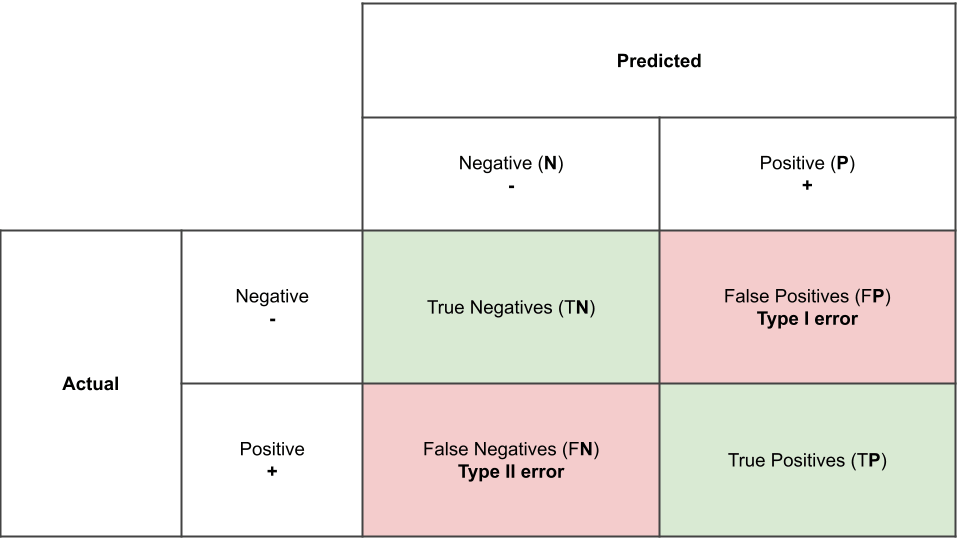

In [4]:
from PIL import Image
import requests
im = Image.open(requests.get(url='https://www.nbshare.io/static/snapshots/cm_colored_1-min.png', stream=True).raw)
im

In [4]:
tn = data.iloc[0,0]; fp=data.iloc[0,1]
fn = data.iloc[1,0]; tp=data.iloc[1,1]
fpr = fp/data.iloc[0,2]; tpr = tp/data.iloc[1,2]
print(f'알러지가 없는데 있다고 진단할 확률(허위양성율, fpr)은 {fpr*100} %')
print(f'알러지가 있는데 없다고 진단할 확률(참음성율, tpr)은 {tpr*100} %')

알러지가 없는데 있다고 진단할 확률(허위양성율, fpr)은 1.0 %
알러지가 있는데 없다고 진단할 확률(참음성율, tpr)은 100.0 %


## <font color='red'> 알러지 진단을 받았다면 실제로 알러지일 확률은 겨우 ‘50.25%’이다. 

In [5]:
print(f'알러지 진단을 받았는데 실제 알러지일 확률(양성 정밀도)은 {tp/(fp+tp)*100} %')

알러지 진단을 받았는데 실제 알러지일 확률(양성 정밀도)은 50.25125628140703 %


### 아주 적은 비율의 알러지를 가진 모집단일 경우 진단 테스트(예측 모형) 정확도는 판단 오류를 준다. 
### 모집단의 알러지 비중이 커질수록 진단을 받았다면 실제 알러지일 확률은 증가한다. 
### 불균형데이터가 많은 의료분야 검사의 경우 진단 테스트의 정확도, 재현율, 정확도를 모두 고려하여야 한다.

## 데이터 불러오기

### kaggle('../data/creditcard.csv'')로 search
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [6]:
df = pd.read_csv("../data/creditcard.csv")
df.head()
df.shape

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)

## 데이터 전처리

In [7]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


In [9]:
df= df.sample(frac=0.1)

In [10]:
X = df.drop(['Class', 'Amount'], axis=1).iloc[:, 4:7]
y = df['Class']

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [12]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state=11)
y_predict = lgr.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.9984202211690363

In [13]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5688
           1       0.50      0.22      0.31         9

    accuracy                           1.00      5697
   macro avg       0.75      0.61      0.65      5697
weighted avg       1.00      1.00      1.00      5697



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

0.990938063143891

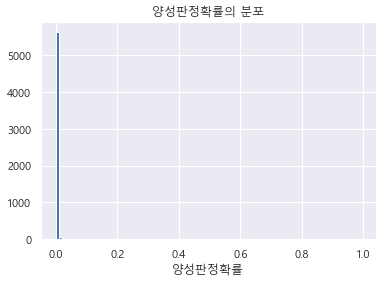

In [14]:
y_scores = lgr.predict_proba(X_test)[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포'); plt.xlabel('양성판정확률')
np.max(y_scores)

In [15]:
y_scores

array([0.00037998, 0.00065308, 0.00011645, ..., 0.00137451, 0.00018638,
       0.00024944])

## 1. 손실함수 조정(Sklearn utils)

In [16]:
model = LogisticRegression(random_state=11, class_weight='balanced')
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5688
           1       0.01      0.89      0.03         9

    accuracy                           0.91      5697
   macro avg       0.51      0.90      0.49      5697
weighted avg       1.00      0.91      0.95      5697



In [17]:
y.value_counts(normalize=True)
negative = y.value_counts(normalize=True)[0]
positive = y.value_counts(normalize=True)[1]

0    0.99835
1    0.00165
Name: Class, dtype: float64

In [18]:
model = LogisticRegression(random_state=11, class_weight={0: positive, 1: negative})
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5688
           1       0.02      0.89      0.03         9

    accuracy                           0.91      5697
   macro avg       0.51      0.90      0.49      5697
weighted avg       1.00      0.91      0.95      5697



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

0.9999899298343274

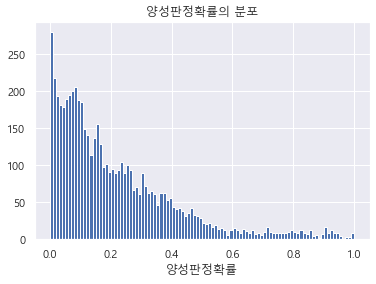

In [19]:
y_scores = model.predict_proba(X_test)[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포'); plt.xlabel('양성판정확률')
np.max(y_scores)

## 1. Sklearn utils
### 손실함수 조정이 가능한 알고리즘

In [20]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)
# metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss, matthews_corrcoef
from scipy.stats import ks_2samp

In [21]:
classifiers = {}
classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})
classifiers.update({'SVC': SVC(class_weight='balanced', max_iter= 100, probability=True)})
classifiers.update({'Decisiontree': DecisionTreeClassifier(class_weight='balanced')})
classifiers.update({'Extratree': ExtraTreesClassifier(class_weight='balanced', n_estimators=250)})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100)})

In [22]:
from tqdm import tqdm_notebook
kf = KFold(n_splits=2)
results = {}

for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2,
                          scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
             }
 
    results.update({classifier_label: result})

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,AUROC,Average PR,F1-score,Log_loss,Brier_score
SVC,0.420261,0.001568,0.0,0.02493,0.00158
Random Forest,0.770618,0.473429,0.2,0.026281,0.001198
Extratree,0.767639,0.369838,0.333333,0.026304,0.001212
Decisiontree,0.666139,0.112164,0.333333,0.072752,0.002106
LGR,0.963334,0.289722,0.028829,0.304476,0.086388


# 2 SMOTE
- 가우시안 나이브 등과 같은 알고리즘은 Class weight 파라미터가 없음

In [24]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [25]:
from collections import Counter
#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))

normal data distribution: Counter({0: 28434, 1: 47})


In [26]:
X_smote, y_smote = SMOTE().fit_resample(X,y) # SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

SMOTE data distribution: Counter({0: 28434, 1: 28434})


In [27]:
smote_pipeline = make_pipeline(SMOTE(random_state=4),
                               lgr)

In [28]:
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: ")

print(classification_report(y_test, smote_prediction))
print(confusion_matrix(y_test, smote_prediction))

Confusion Matrix: 
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      5688
           1       0.01      0.78      0.03         9

    accuracy                           0.91      5697
   macro avg       0.51      0.84      0.49      5697
weighted avg       1.00      0.91      0.95      5697

[[5179  509]
 [   2    7]]


In [30]:
cross_val_score(smote_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.87180433, 0.79307668])

## <font color='red'> 선교차검증 후 데이터 전처리

In [31]:
from imblearn.pipeline import make_pipeline
imba_pipeline = make_pipeline(StandardScaler(), 
                              SMOTE(random_state=42), 
                              RandomForestClassifier(random_state=13))

In [32]:
X = df.drop(['Class', 'Amount'], axis=1).iloc[:, 4:7]
y = df['Class']

In [33]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [34]:
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.59994378, 0.72441183])

In [35]:
smote_prediction = imba_pipeline.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, smote_prediction))
print(confusion_matrix(y_test, smote_prediction))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5688
           1       0.04      0.44      0.08         9

    accuracy                           0.98      5697
   macro avg       0.52      0.71      0.53      5697
weighted avg       1.00      0.98      0.99      5697

[[5597   91]
 [   5    4]]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

1.0

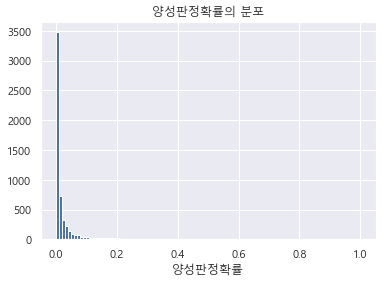

In [36]:
y_scores = imba_pipeline.predict_proba(X_test)[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포'); plt.xlabel('양성판정확률')
np.max(y_scores)

### 소수 범주 자료를 다수 범주 자료의 60%까지 오버샘플링(sampling_strategy = 0.6)


In [37]:
kf = KFold(n_splits=2)
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.59994378, 0.72441183])

In [38]:
for i in [0.3, 0.4, 0.5, 0.6, 0.7]:
    imba_pipeline = make_pipeline(StandardScaler(),
                                  SMOTE(sampling_strategy = i, random_state=42),
                                  RandomForestClassifier(random_state=13))
    print(f'sampling_strategy = {i}')
    cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)
    print('*'*100)

sampling_strategy = 0.3


array([0.625729  , 0.72718057])

****************************************************************************************************
sampling_strategy = 0.4


array([0.64658855, 0.72709267])

****************************************************************************************************
sampling_strategy = 0.5


array([0.62353004, 0.72621371])

****************************************************************************************************
sampling_strategy = 0.6


array([0.62374994, 0.72573027])

****************************************************************************************************
sampling_strategy = 0.7


array([0.6450053 , 0.72533474])

****************************************************************************************************


## Probability Threshold Moving
## 1.  Optimal Threshold for ROC Curve

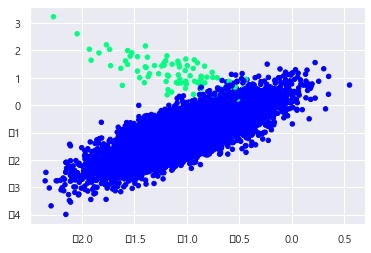

In [3]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='winter')

In [40]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

LogisticRegression()

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

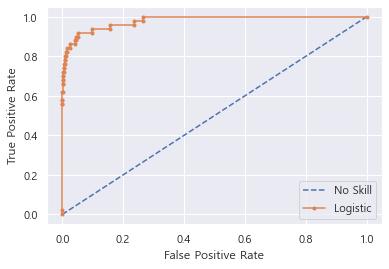

In [41]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

The Geometric Mean or G-mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and
the specificity. One approach would be to test the model with each threshold returned from the call roc auc score() and select the threshold with the largest G-mean value.

In [42]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.016153, G-mean=0.933


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

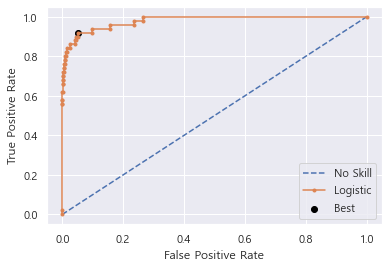

In [43]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

It turns out there is a much faster way to get the same result, called the Youden’s J statistic. The statistic is calculated as:
### J = Sensitivity + Specificity − 1 = Sensitivity + (1 − FalsePositiveRate) − 1 =  TruePositiveRate − FalsePositiveRate

In [44]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.016153


## 2. Optimal Threshold for Precision-Recall Curve
### Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.

Best Threshold=0.256036, F-measure=0.756


Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

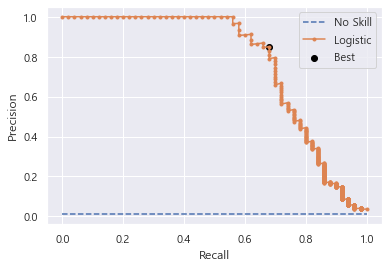

In [45]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)

# convert to f-measure
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-measure
ix = np.argmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

## 3. Optimal Threshold Tuning
Sometimes, we simply have a model and we wish to know the best threshold directly. In this case, we can define a set of thresholds and then evaluate predicted probabilities under each in order to find and select the optimal threshold.

In [46]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [47]:
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
from sklearn.metrics import f1_score
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-measure=%.5f' % (thresholds[ix], scores[ix]))

LogisticRegression()

Threshold=0.251, F-measure=0.75556


## 다양한 metrics로 Tuning

In [48]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.model_selection import RandomizedSearchCV

In [49]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')

In [50]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'accuracy')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



In [51]:
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'recall')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



In [52]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'precision')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4950
           1       1.00      0.22      0.36        50

    accuracy                           0.99      5000
   macro avg       1.00      0.61      0.68      5000
weighted avg       0.99      0.99      0.99      5000



In [53]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'f1')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



In [54]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=3)

params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = ftwo_scorer)
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



# END